In [ ]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [ ]:
import matplotlib.pyplot as plt 

# Test limit of how many ptiles we can run through the function

In [ ]:
import torch
from bliss.grid import shift_sources
import matplotlib.pyplot as plt 

In [ ]:
device = torch.device("cuda:0")

In [ ]:
images = torch.randn(128 * 100, 1, 53, 53).to(device)
locs=torch.rand(128* 100, 2).to(device)
images[1000:10000] = 0.0

In [ ]:
new_images = shift_sources(images, locs, tile_slen=4, slen=52, center=True)

In [ ]:
new_images.shape

torch.Size([12800, 1, 52, 52])

In [ ]:
assert not torch.any(torch.logical_or(torch.isnan(new_images), torch.isinf(new_images)))


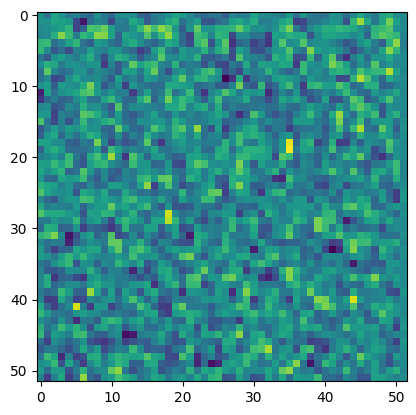

In [ ]:
plt.imshow(new_images[0, 0].cpu())

# Investigate NaN's with images

In [ ]:
import torch
from astropy.table import Table
from torch.utils.data import DataLoader

from bliss.datasets.generate_blends import generate_dataset, parse_dataset
from bliss.datasets.io import save_dataset_npz
from bliss.datasets.lsst import get_default_lsst_psf
from bliss.datasets.saved_datasets import SavedGalsimBlends
from bliss.datasets.table_utils import column_to_tensor
from bliss.encoders.binary import BinaryEncoder
from bliss.encoders.deblend import GalaxyEncoder
from bliss.encoders.detection import DetectionEncoder


In [ ]:
from bliss import HOME_DIR
from pathlib import Path


home_dir = HOME_DIR

ae_state_dict = home_dir / "experiment" / "models" / "autoencoder_42_42.pt"

catsim_table = Table.read(home_dir / "data" / "OneDegSq.fits")
all_star_mags = column_to_tensor(
    Table.read(home_dir / "data" / "stars_med_june2018.fits"), "i_ab"
)
psf = get_default_lsst_psf()
blends_ds = generate_dataset(10, catsim_table, all_star_mags, psf, 10)

saved_ds_path = Path("tmp") / "train_ds.npz"
save_dataset_npz(blends_ds, saved_ds_path)
saved_ds1 = SavedGalsimBlends(saved_ds_path, keep_padding=True)


100%|██████████| 10/10 [00:00<00:00, 18.16it/s]


AssertionError: overwriting existing ds

In [ ]:

dl1 = DataLoader(saved_ds1, batch_size=32, num_workers=0)
galaxy_encoder = GalaxyEncoder(ae_state_dict)


In [ ]:
for b in dl1:
    im, tc, pds = parse_dataset(b)
    galaxy_encoder.get_loss(im, pds, tc)


/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax_galsim/image.py:469: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.zeros(shape=shape, dtype=dtype)
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:188: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/home/imendoza/.cach

AssertionError: 

In [ ]:
from bliss.render_tiles import get_images_in_tiles, render_galaxy_ptiles
from einops import rearrange

_, nth, ntw, _ = tc.locs.shape

image_ptiles = get_images_in_tiles(im, 4, 52)
image_ptiles_flat = rearrange(image_ptiles, "n nth ntw c h w -> (n nth ntw) c h w")
tile_locs_flat = rearrange(tc.locs, "n nth ntw xy -> (n nth ntw) xy")
galaxy_params_flat = galaxy_encoder.forward(image_ptiles_flat, tile_locs_flat)


In [ ]:

galaxy_params_pred = rearrange(
    galaxy_params_flat, "(b nth ntw) d -> b nth ntw d", nth=nth, ntw=ntw
)
recon_ptiles = render_galaxy_ptiles(
    galaxy_encoder._dec,
    tc.locs,
    galaxy_params_pred,
    tc["galaxy_bools"],
    52, 
    4, 
    1,
)

In [ ]:
from bliss.render_tiles import _render_centered_galaxies_ptiles
from bliss.grid import shift_sources

b, nth, ntw, _ = tc.locs.shape

locs_flat = rearrange(tc.locs, "b nth ntw xy -> (b nth ntw) xy", xy=2)
galaxy_bools_flat = rearrange(tc['galaxy_bools'], "b nth ntw 1 -> (b nth ntw) 1")
galaxy_params_flat = rearrange(galaxy_params_pred, "b nth ntw d -> (b nth ntw) d")

# NOTE: size of tiles here is galaxy_decoder size, not `ptile_slen`!.
centered_galaxies = _render_centered_galaxies_ptiles(
    galaxy_encoder._dec, galaxy_params_flat, galaxy_bools_flat, 1
)
assert centered_galaxies.shape[-1] == galaxy_encoder._dec.slen
assert galaxy_encoder._dec.slen % 2 == 1  # so centered in central pixel

uncentered_galaxies = shift_sources(
    centered_galaxies, locs_flat, tile_slen=4, slen=52, center=False
)

In [ ]:
uncentered_galaxies[161, 0]

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

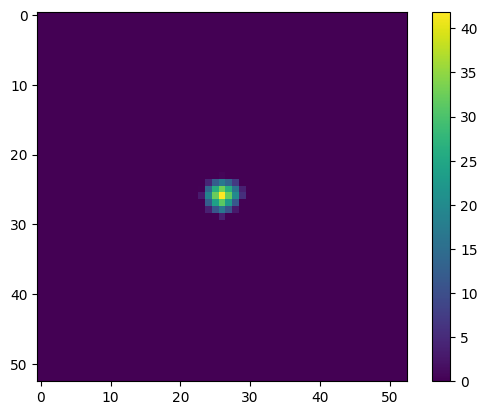

In [ ]:
plt.imshow(centered_galaxies[95, 0].detach().numpy())
plt.colorbar()

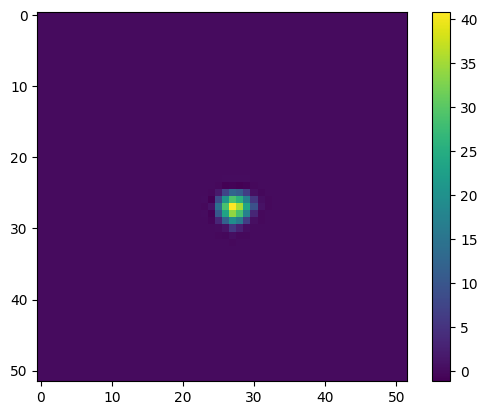

In [ ]:
plt.imshow(uncentered_galaxies[95, 0].detach().numpy())
plt.colorbar()

In [ ]:
centered_galaxies.sum(axis=(1,2,3)).nonzero()

tensor([[ 92],
        [ 95],
        [455],
        [926],
        [983]])

In [ ]:
tc['galaxy_bools']

tensor([[[[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [1.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0

In [ ]:
recon_ptiles[8, 0, 0]

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]])

In [ ]:
im = torch.zeros(2, 1, 53, 53)
im[:, 0, 25, 25] = 1.0
locs = torch.ones(2, 2)
im2 = shift_sources(im, locs, tile_slen=4,slen=52, center=False)

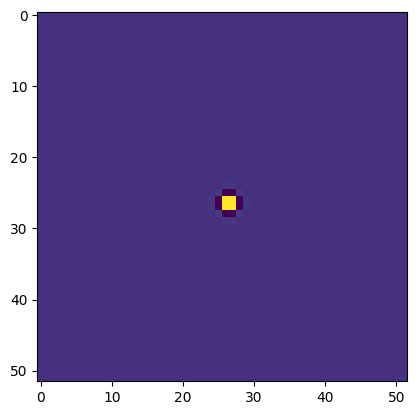

In [ ]:
plt.imshow(im2[0, 0, :, :])

# Test gradients

In [ ]:
from torch_jax_interop import WrappedJaxFunction, jax_to_torch
# from bliss.grid import _shift_source_jax
from jax2torch import jax2torch
from functools import partial

In [ ]:
from functools import partial

import torch
from einops import pack, rearrange, reduce, unpack
from jax import Array, jit, vmap
from jax_galsim import Image, InterpolatedImage
from torch import Tensor
from torch.nn.functional import grid_sample
from torch_jax_interop import jax_to_torch, torch_to_jax
from bliss.grid import get_shift_sources2, shift_sources
from jax2torch import jax2torch


def _shift_source_jax2(image: Array, offset: Array, *, slen:int=52):
    img = Image(image, scale=0.2)
    ii = InterpolatedImage(img, scale=0.2)
    fimg = ii.drawImage(nx=slen, ny=slen, scale=0.2, offset=offset, method="no_pixel")
    return fimg.array

def _shift_source_3(image: Array, offset: Array): 
    return _shift_source_jax2(image, offset, slen=52)

shift_sources2 = get_shift_sources2(slen=52, pixel_scale=0.2)
_shift_sources = jax2torch(vmap(jit(shift_sources2)))

def shift_sources4(images:Tensor, locs:Tensor, tile_slen:int=4, slen:int=52, center:bool=False):
    final_images = torch.zeros(images.shape[0], 1, slen, slen, device=images.device)

    flux = reduce(images, "n 1 h w -> n", "sum")
    mask = flux > 0
    _images = images[mask]
    _locs = locs[mask]

    sgn = -1 if center else 1
    images_flat = rearrange(_images, "n 1 h w -> n h w")
    offsets = (_locs * tile_slen - tile_slen / 2) * sgn
    shifted_images = _shift_sources(images_flat, offsets)
    final_images[mask, 0] = shifted_images
    return final_images



In [ ]:
# image = torch.concatenate([torch.randn(5, 1, 53, 53, requires_grad=True), 
                        #    torch.zeros(5, 1, 53, 53, requires_grad=True)])
image = torch.randn(10, 1, 53, 53, requires_grad=True)
locs = torch.rand(10, 2, requires_grad=False) 


In [ ]:
new_images = shift_sources4(image, locs, tile_slen=4, slen=52)
new_images.shape

torch.Size([10, 1, 52, 52])

In [ ]:
new_images[0,0,0,0].backward()

In [ ]:
# image.grad

In [ ]:
# new_images[0, 0, 0].backward()

In [ ]:
new_images2 = shift_sources(image, locs, tile_slen=4, slen=52)
new_images2.shape

/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax_galsim/image.py:469: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.zeros(shape=shape, dtype=dtype)
/home/imendoza/.cache/pypoetry/virtualenvs/bliss-deblender-W0ocb7P7-py3.10/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:188: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


torch.Size([10, 1, 52, 52])

In [ ]:
# new_images2[0, 0, 0].backward()

In [ ]:
# image.grad